<a id='top'></a>
# Sant Boi Buildings Energy Consumption

## Context 

A dataset of buildings from Sant Boi de Llobregat was collected and an energy consumption model (a physical and static one) was implemented to get an estimate of annual energy consumption for each building[[1]](#references).

A considerable amount of data about building stock in Spain is already a public asset, which can be accessed via [Catastro](http://www.catastro.meh.es/). However, that doesn't happen when it comes to data about energy consumption. 

Sustainability implies governance. Public data is an important tool these days to enable transparency and informed decission making. This is of great importance when it comes to public energy policies, which deeply determine our environmental and social systems. In order to protect our ecosystems and engage citizens with policy making, data must be accesible.
<a id='context'></a>

There are already some initiatives aligned with the present project such as [urbanZEB](http://urbanzeb.com/) and [this study of energy consumption in the Municipality of Rubí](http://rubienergia.300000kms.net/). Using models in this context could result in interesting results.

However, we must not forget that models may tend to produce deceiving outcomes. This can happen when we (modelers) do not use all the variables necesary or when using the wrong type. A clear example of this is the IMPACT system designed to evaluate new teacher's professional performance.[[2]](#references)

<a id='jeavons'></a>
In the EU context, low income families are susceptible of suffering [energy poverty](https://www.energypoverty.eu/about/what-energy-poverty).

In the opposite direction, high income families tend to consume more than less wealth ones. Therefore, models by themselves mean nothing, as it would be necessary to educate consumers to be aware that increasing efficiency must be accompanied by a conscious reduction in consumption. Otherwise, an increase on energy demand could be produced, as the Jevons Paradox states[[3]](#references).

Hence, demographic, social variables and also others related to climate (like temperature, precipitation, rise and sundown hours) should be taken into account to enrich this type of study. Furthermore, time could be included, and thus, get a more accurate prediction of energy consumption. 

Anyhow, this goes beyond the scope and aim of the present excercise. 

To see previous work about this project, variables considered and its context [clic here](https://github.com/carlosdavila91/santboi_eda).

<a id='goals'></a>
## Goals

This notebook aims to explore strengths (and weaknesses) of data and Machine Learning models regarding sustainable urban planning and energy consumption.

In short, the aims are:

* Practicing Machine Learning: follow along the basic structure of an end to end Machine Learning Project
* Discussing the potential of Machine Learning in the mentioned context.
* Implementing a model to predict energy consumption.

<a id='measure'></a>
## Performance measure

The performance measure is an indicator that gives an idea of how much error the system tipically makes in its predictions. It is well defined in the picture bellow.

![](img/error.png)

The performance measure selected for this project is Root Mean Squared Error (RMSE), as it is a typical error measure when it comes to Regression tasks[[3]](#references). It is described as follows:

$$RMSE(X,h)=\sqrt{\frac{1}{m}\sum^m_{i=1}(h(x^{(i)}) - y^{(i)})^2}$$

Where,

* $X$ is the matrix containing all the features, excluding the label or target variable
* $h$ is the hypothesis, i.e., the model function
* $m$ is the length of the dataset, i.e., the number of instances or builgings in it
* $x^{(i)}$ is a vector of all the feature values (excluding the label) of the $i^{th}$ instance in the dataset. Hence, $h(x^{(i)})$ gives us the "predicted $y$"
* $y$ is the real target value

This performance measure imputes higher weight for large errors.

## Asumptions

The data available have many limitations, mainly:
* the target variable is biased and is hypothetical, 
* there are many errors and outliers derived from how data were collected. 

However, this is an opportunity to discuss the potential of Machine Learning in the context of sustainable urban planning and the necessity of open and high quality data to make informed decisions and favour sustainablity and governance. 

Thus, it is asumed that the energy consumption variable is real rather than an estimation.

It is assumed that anyone that reach this notebook will have some basic familiarity with python and Machine Learning. Just in case, it is going to be written to be as accessible as possible to someone with little to no knoweledge to them.

![](img/ml-explained.jpeg)

Sometimes, variables are refered as attributes or features, being attributes the prefered one.

## Configuration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import shapefile as shp
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

mpl.rcParams['figure.figsize'] = (10, 6)
sns.set(style = 'whitegrid', font_scale = 1)

## Get the Data

In [2]:
buildings = pd.read_csv("../santboi/data/1906SB_collection_heatd.csv")

## Quick Data Exploration

In [3]:
print('ORIGINAL DATA:')
buildings.info(null_counts=True)

ORIGINAL DATA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X Coord                    746 non-null    float64
 1   Y Coord                    746 non-null    float64
 2   District                   814 non-null    object 
 3   Year                       814 non-null    int64  
 4   Main Orientation           814 non-null    object 
 5   GF Usage                   814 non-null    object 
 6   Roof Surface               814 non-null    float64
 7   Facade Surface             814 non-null    float64
 8   Openings Surface           814 non-null    float64
 9   Wrapping Surface           814 non-null    float64
 10  Party Wall Surface         814 non-null    float64
 11  Contact w/Terrain Surface  814 non-null    float64
 12  Type of Roof               814 non-null    object 
 13  Type of Opening            814 non-

Print the data to see how it looks like

In [4]:
buildings.head()

,X Coord,Y Coord,District,Year,Main Orientation,GF Usage,Roof Surface,Facade Surface,Openings Surface,Wrapping Surface,Party Wall Surface,Contact w/Terrain Surface,Type of Roof,Type of Opening,Type of Party Wall,Type of Facade,Number of Floors,Number of Courtyards,Number of Dwellings,Heat Demand
0,2.032087,41.348370,Marianao,1977,E,Commercial,165.43,208.50,56.1150,1473.28,150.9,150.00,C2,H4,M2,F3,5,1,5,44.251546
1,2.032074,41.348412,Marianao,1978,W,Commercial,417.41,547.35,218.9400,2524.31,36.6,420.00,C2,H3,M2,F3,5,2,19,38.328312
2,2.032024,41.348669,Marianao,1976,E,Commercial,202.00,282.00,112.8000,1637.97,108.9,202.07,C2,H3,M2,F3,5,2,14,58.794629
3,2.043332,41.338324,Vinyets,1959,NW,Dwelling,96.00,148.80,38.4024,489.60,0.0,96.00,C1,H3,0,F1,3,0,2,126.321738
4,2.043382,41.338281,Vinyets,1958,NE,Dwelling,45.00,61.38,18.4170,418.31,0.0,80.00,C1,H4,0,F1,2,1,2,69.562085


Latitude and longitude were obtained via the Spanish Cadastre API. There are 68 nulls in those variables as a result of poorly collected cadastral references.

Let's see what categorical data contains and with what frequency.

In [5]:
buildings["District"].value_counts()

Marianao    499
Vinyets     315
Name: District, dtype: int64

This is an important variable, as we the approach of the study is highly dependent on the terreitory.

In [6]:
buildings["Main Orientation"].value_counts()

N     134
S     131
E     109
W     106
SE     98
NE     86
NW     79
SW     71
Name: Main Orientation, dtype: int64

In [7]:
buildings["GF Usage"].value_counts()

Dwelling      401
Commercial    355
Storage        41
Industrial     17
Name: GF Usage, dtype: int64

The same occurs with the following, where categories are a direct representation of the physical characteristics of the corresponding wrapping surface.

Let's see some statistics.

In [8]:
buildings.describe()

,X Coord,Y Coord,Year,Roof Surface,Facade Surface,Openings Surface,Wrapping Surface,Party Wall Surface,Contact w/Terrain Surface,Number of Floors,Number of Courtyards,Number of Dwellings,Heat Demand
count,746.000000,746.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000,814.000000
mean,2.037112,41.344455,1958.713759,188.012064,283.197881,92.051687,1174.339019,89.446564,191.163845,3.819410,1.067568,8.509828,78.686759
std,0.005807,0.004975,24.095145,162.277031,346.681371,154.381926,991.088501,144.038287,166.748749,1.811693,1.209477,10.797443,41.569118
min,2.028457,41.334829,1700.000000,30.080000,14.280000,2.570000,150.920000,0.000000,38.610000,1.000000,0.000000,1.000000,5.977362
25%,2.032491,41.339325,1958.000000,91.000000,77.334300,18.899490,494.850000,0.000000,93.812500,2.000000,0.000000,1.000000,48.330863
50%,2.034446,41.346671,1967.000000,129.565000,157.920000,40.266405,851.655000,33.985500,131.500000,4.000000,1.000000,4.000000,69.391495
75%,2.043433,41.349227,1973.000000,224.587500,344.475000,94.001554,1497.847500,117.810000,225.532500,5.000000,2.000000,12.000000,99.243290
max,2.046343,41.352760,1979.000000,1367.000000,2765.940000,1795.254000,6159.730000,1287.270000,1405.000000,8.000000,7.000000,83.000000,233.075410


Complemented with plots.

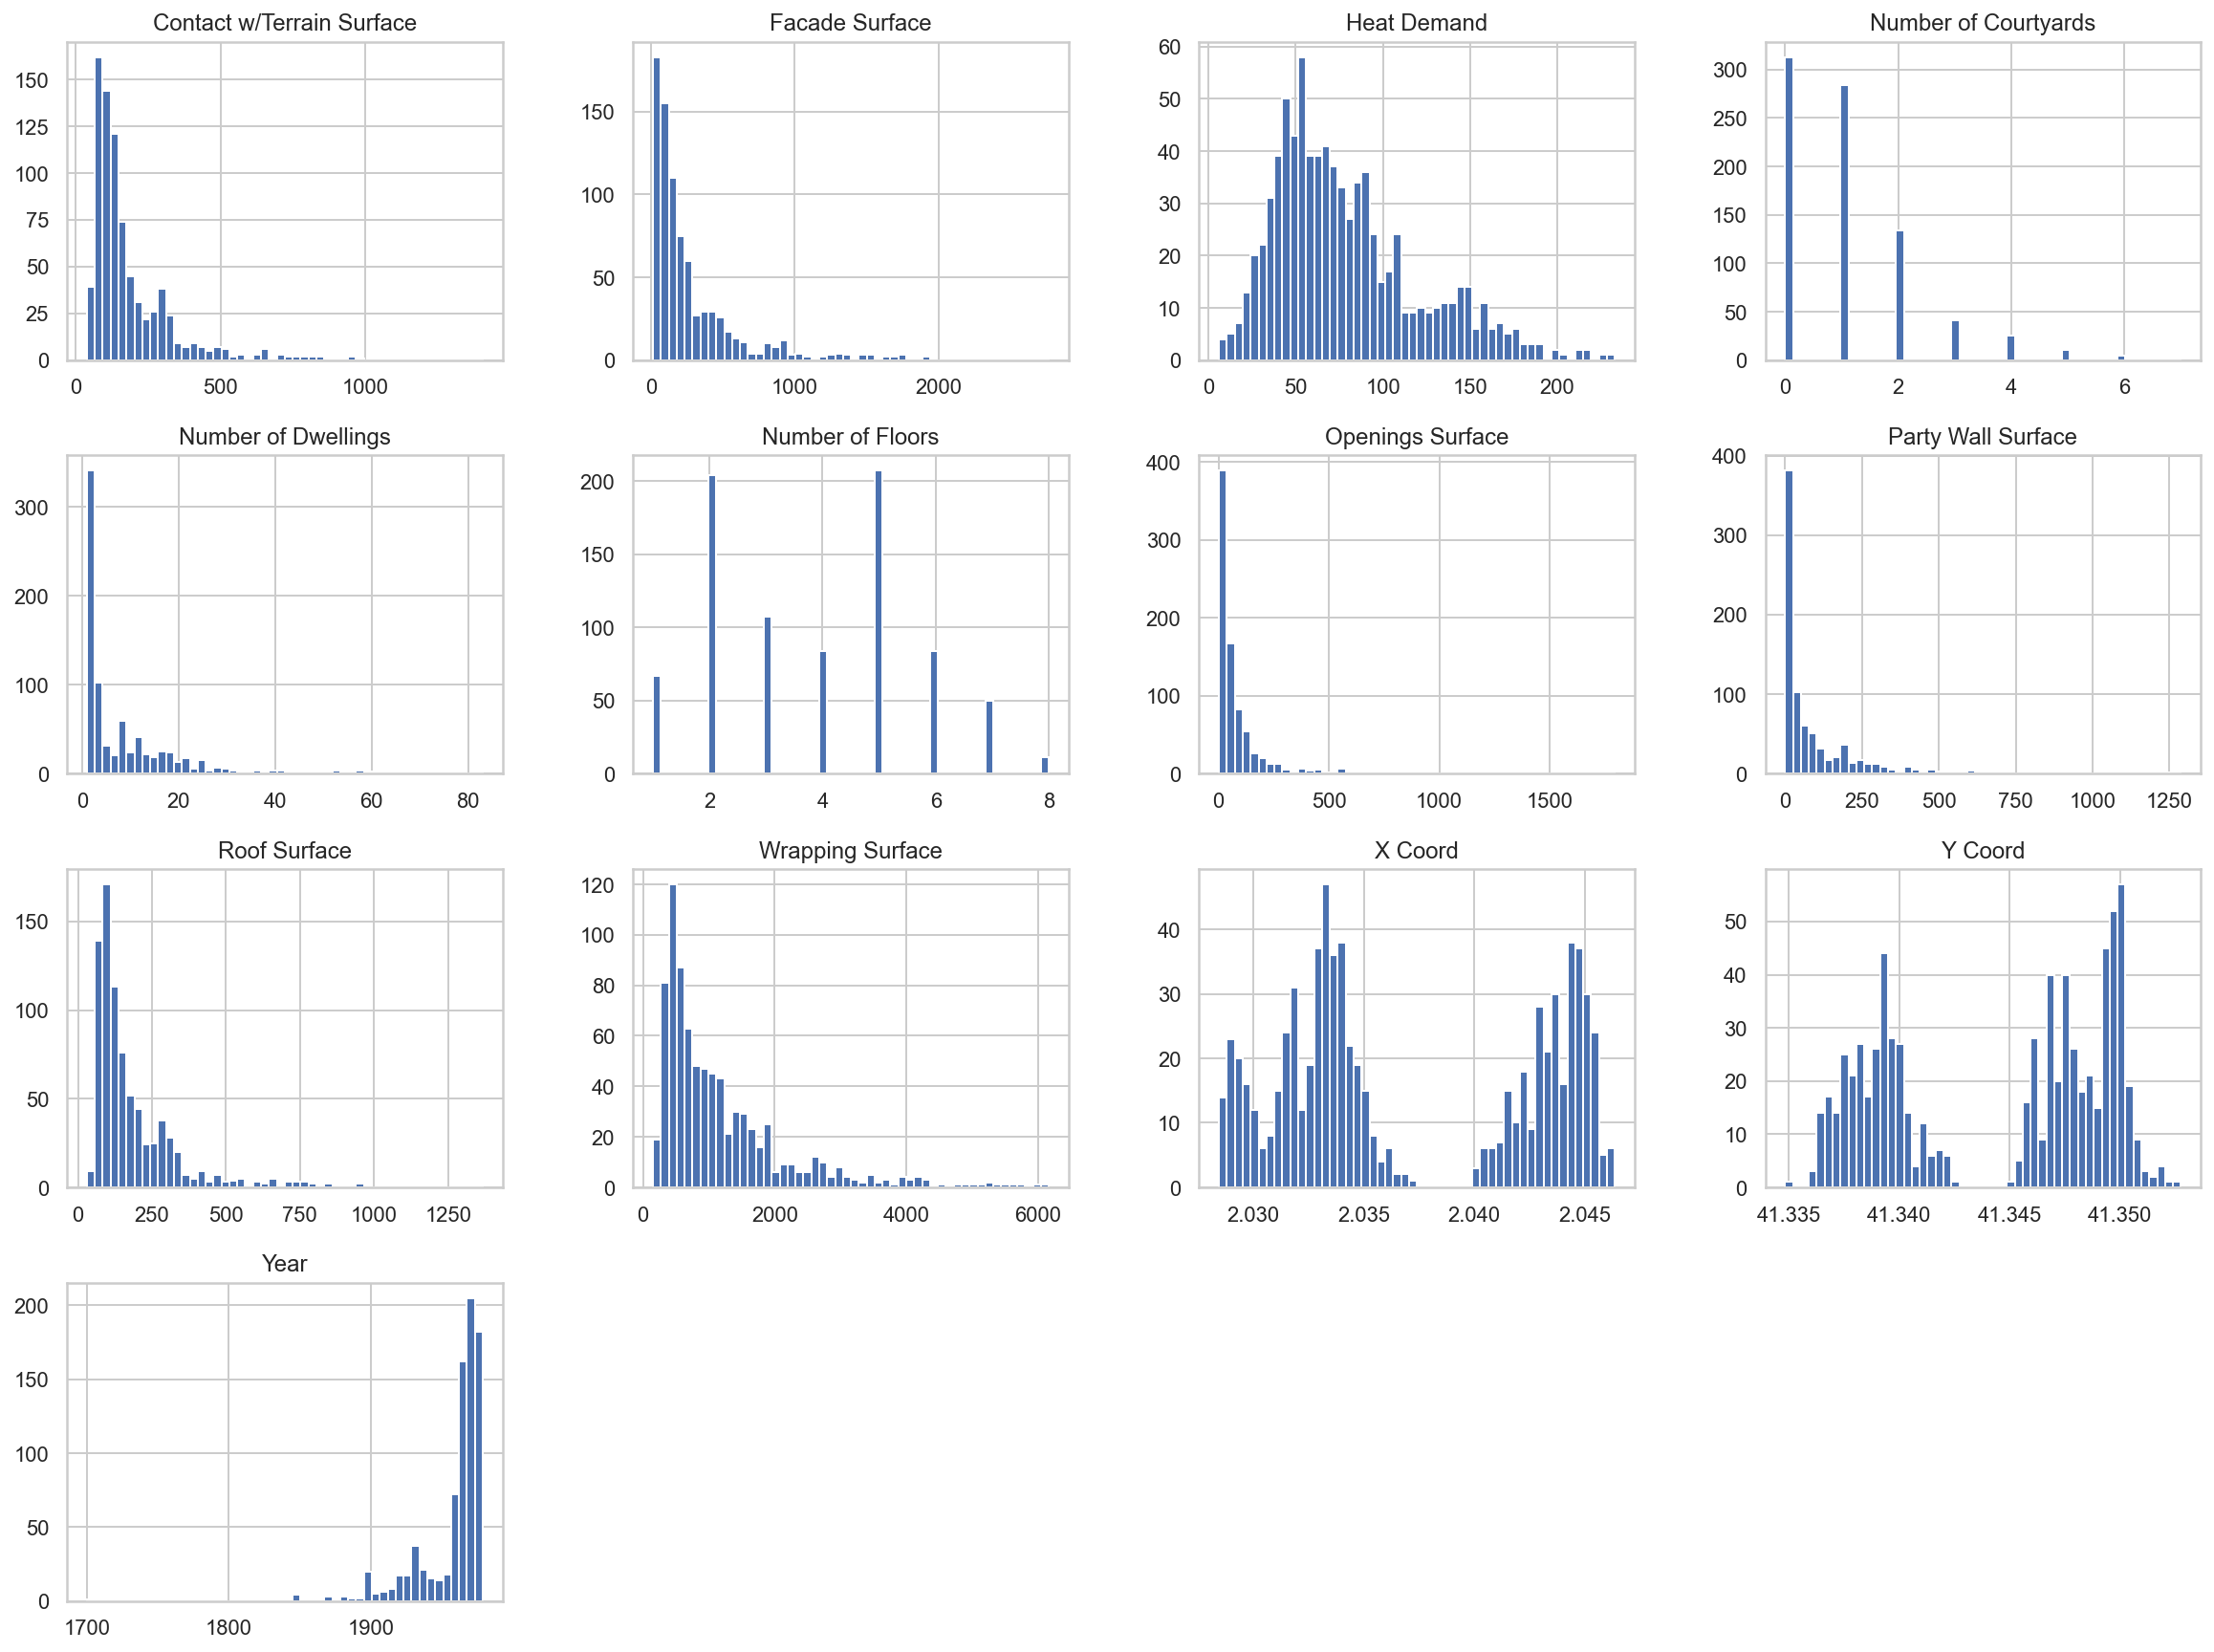

In [9]:
buildings.hist(bins=50, figsize=(20,15))
plt.show()

Now we can observe some peculiarities in data:

* Most buildings have 2 or 5 heights
* Many distributions are _tail-heavy_
* The Attributes have different scales
* Heat demand shows a bimodal distribution (i.e., two peaks) which indicates an important category to be producing this difference.

# Create the Test Set

After getting some quick look at the data, the next thing we need to do is puting aside the test set (i.e., the dataset we will use to test our model's performance with data that it does not know) to ignore it until the appropiate moment.

The approach of this study is territory-wise. This must be taken into account when splitting the dataset in the train and test set. Data in both sets must be representative of each District.

As will be seen later, another fundamental variable will be the `Number of Floors` of buildings. Hence, data is stratifyed in relation to this variable too.

Here, the proportions in the whole dataset for both variables.

In [10]:
print("DISTRICT PROPORTIONS:")
buildings["District"].value_counts(normalize=True)

DISTRICT PROPORTIONS:


Marianao    0.613022
Vinyets     0.386978
Name: District, dtype: float64

In [11]:
print("NUMBER OF FLOORS PROPORTIONS:")
buildings["Number of Floors"].value_counts(normalize=True)

NUMBER OF FLOORS PROPORTIONS:


5    0.254300
2    0.250614
3    0.131450
6    0.103194
4    0.103194
1    0.082310
7    0.061425
8    0.013514
Name: Number of Floors, dtype: float64

Now we are prepared to implement **Scikit-Learn's** `StratifiedShuffleSplit` class. You will see that Scikit-Learn classes are used in several moments. This is the best practice when it comes to automate and make reproducible all the steps in a Machine Learning Project conducted with python.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(buildings, buildings.loc[:,("District", "Number of Floors")]):
    buildings_train_set = buildings.loc[train_index]
    buildings_test_set = buildings.loc[test_index]

In [13]:
print("DISTRICT PROPORTIONS IN TEST SET:")
buildings_test_set["District"].value_counts(normalize=True)

DISTRICT PROPORTIONS IN TEST SET:


Marianao    0.613497
Vinyets     0.386503
Name: District, dtype: float64

In [14]:
print("NUMBER OF FLOORS PROPORTIONS IN TEST SET:")
buildings_test_set["Number of Floors"].value_counts(normalize=True)

NUMBER OF FLOORS PROPORTIONS IN TEST SET:


5    0.257669
2    0.251534
3    0.128834
6    0.104294
4    0.104294
1    0.085890
7    0.055215
8    0.012270
Name: Number of Floors, dtype: float64

# Exploring Data Visually to Gain Insights

This exploration is performed over the training data to avoid early catching patterns in the test data.

Univariate analysis was already performed. [Clic here to see more](https://github.com/carlosdavila91/santboi_eda).

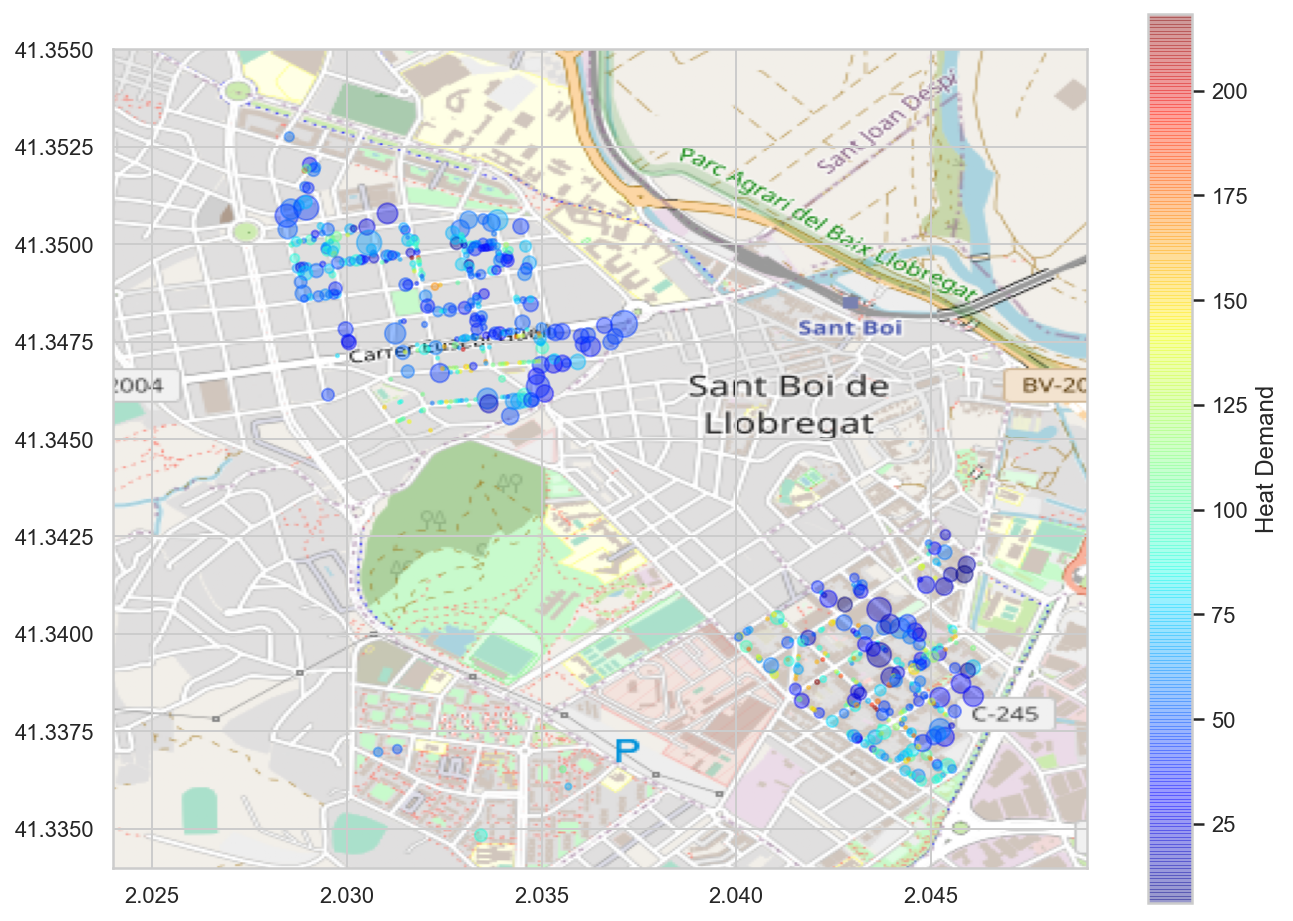

In [15]:
import matplotlib.patches as patches

x = buildings_train_set["X Coord"]
y = buildings_train_set["Y Coord"]
s = buildings_train_set["Number of Dwellings"]
c = buildings_train_set["Heat Demand"]
label = buildings_train_set["Number of Dwellings"]
cmap=plt.get_cmap('jet')

sb_map = plt.imread("img/map.png")
bbox = (2.024, 2.049, 41.334, 41.355)

fig = plt.figure(figsize=(4*6,3*6))
ax = plt.subplot(221)
scat = plt.scatter(x=x, y=y, label=label, alpha=0.4, s=s*2.5, c=c, cmap=cmap)
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
plt.imshow(sb_map, zorder=0, extent = bbox, aspect='equal')
plt.colorbar(scat, label="Heat Demand")

plt.show()

Credits to [openstreemap.org](https://www.openstreetmap.org/) for he image in the background.

## EDA Conclusions

* The smaller the buildings, the greater the Heat Demand Range.
* The size of the building is the most determining variable.

## Correlations

To measure correlation between variables we can calculate the Pearson's correlation coefficient. This will give us an idea of the linear correlations between variables. In our case we want to see how all variables correlate with our target variable, which is `Heat Demand`.

To interpret it we should know that:

* Strong correlations exist as the Pearson's correlation coefficient comes close to `1` or `-1`.
* When it is positive it means that there is a positive correlation, or that both compared variables increase in the same direction. When it is negative, as one of the compared variables increases the other does the opposite.
* Values closer to 0 are indicating weaker linear correlations.

In [16]:
corr_matrix = buildings.corr()
corr_matrix["Heat Demand"].sort_values(ascending=False)

Heat Demand                  1.000000
X Coord                      0.131918
Party Wall Surface          -0.121931
Y Coord                     -0.213433
Number of Courtyards        -0.271266
Roof Surface                -0.351795
Contact w/Terrain Surface   -0.380477
Openings Surface            -0.387990
Year                        -0.413464
Facade Surface              -0.415852
Wrapping Surface            -0.464968
Number of Dwellings         -0.465891
Number of Floors            -0.627875
Name: Heat Demand, dtype: float64

We can complement this matrix with a heat map, which represent the above calculations in a more visual way.

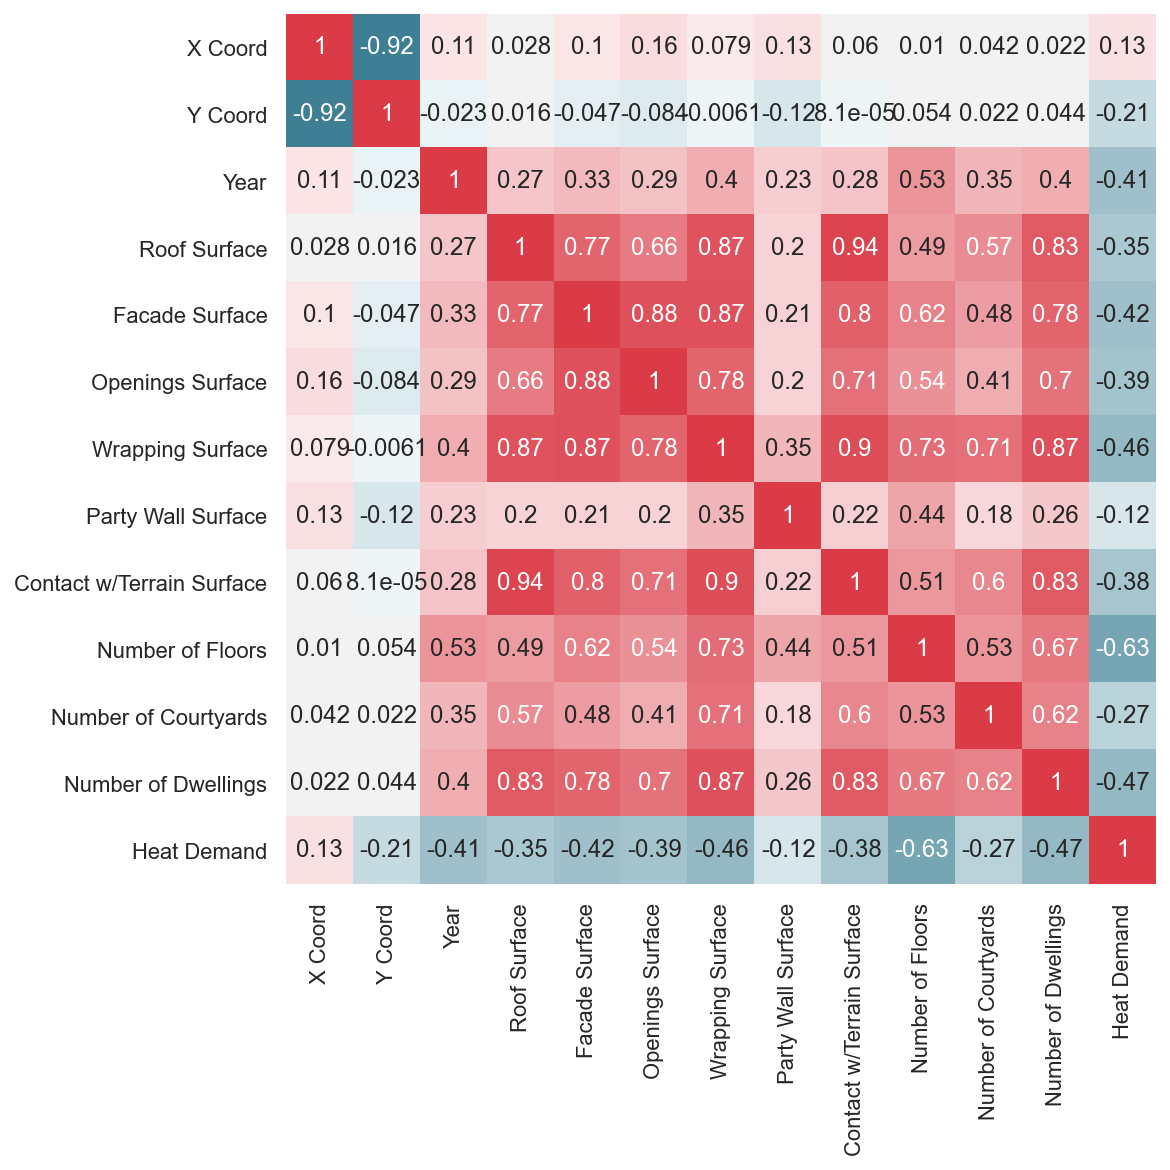

In [17]:
plt.figure(figsize = (8,8))
corr = buildings.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    corr, cmap=cmap, square=True, cbar=False, 
    annot=True, annot_kws={'fontsize':12}
)
plt.yticks(rotation=0)
plt.xticks(rotation=90) 
plt.show()

We can get a much better idea of how variables correlates with scatter plots. In the following, you can see how some patterns appears in the scatterplots (focus on the first row). 

In the diagonal will appear the histogram corresponding to the variable on the y axis, as a scatterplot with the same variable in both axis wont produce relevant information (they would be perfectly correlated with themselves).

As there is only one instance from the year 1700, it is removed from the plots to get a better idea of the patterns.

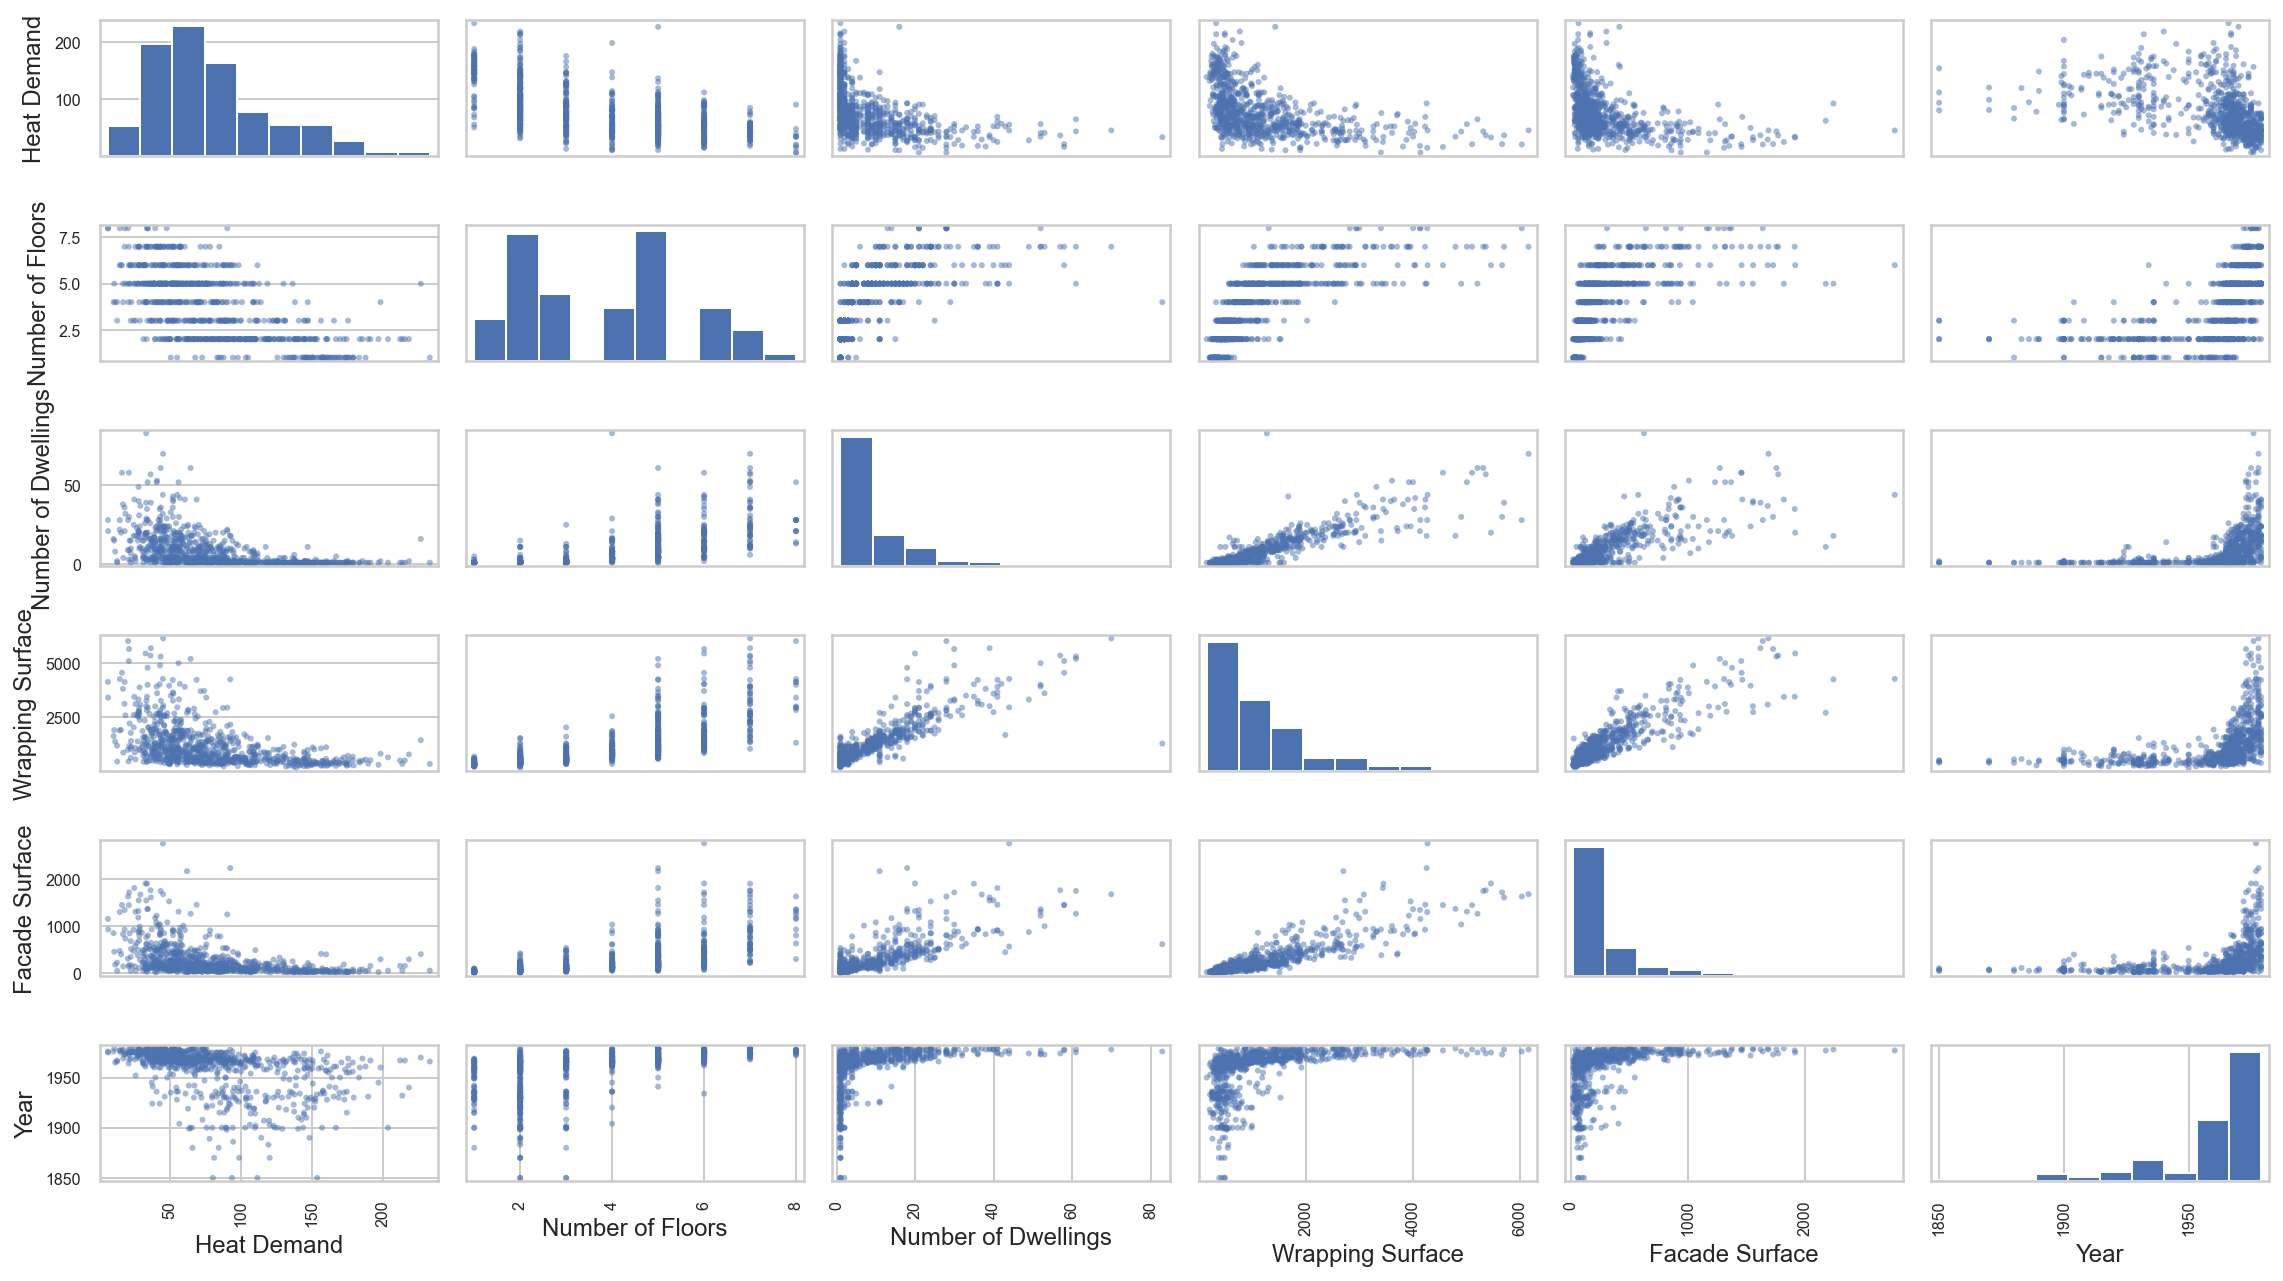

In [18]:
from pandas.plotting import scatter_matrix

attributes=["Heat Demand", "Number of Floors", "Number of Dwellings", 
            "Wrapping Surface", "Facade Surface", "Year"]
scatter_matrix(buildings[buildings.Year > 1800][attributes], figsize=(16,9))
plt.tight_layout()
plt.show()

* There are certain years where most buildings were built.
* There seems to be some type of non-linear correlations between `Number of Dwellings`, `Wrapping Surface` and `Façade Surface` and `Heat Demand`.

<a id='fengineering'></a>
# Attribute Combination

In the course of the project, discretization or binning of numerical attributes was proposed by mentors to see if any pattern arise to help making decisions over what was the best strategy of building renoval.

The produced categories could have an order importance from the physical point of view. E.g., the construction period may determine how buildings are constructed; being oriented to S is better than N, or being a small sized building (in terms of dwellings, number of floors, etc.) account for a higher energy demand for HVAC systems.

According to Khun and Johnson[[4]](#references), this should be a last resource approach in the context of a Machine Learning Project.

In this study we are testing this approach anyway, as there is reasonable knowledge about the meaning of manually produced categories or bins.

In [19]:
labels = ["Before 1900", "From 1900 to 1940", "From 1941 to 1960", "From 1961 to 1971", "From 1971 to 1980"]
buildings["Period"] = pd.cut(x=buildings["Year"], bins=[-np.inf, 1899, 1940, 1960, 1970, 1980], labels=labels)

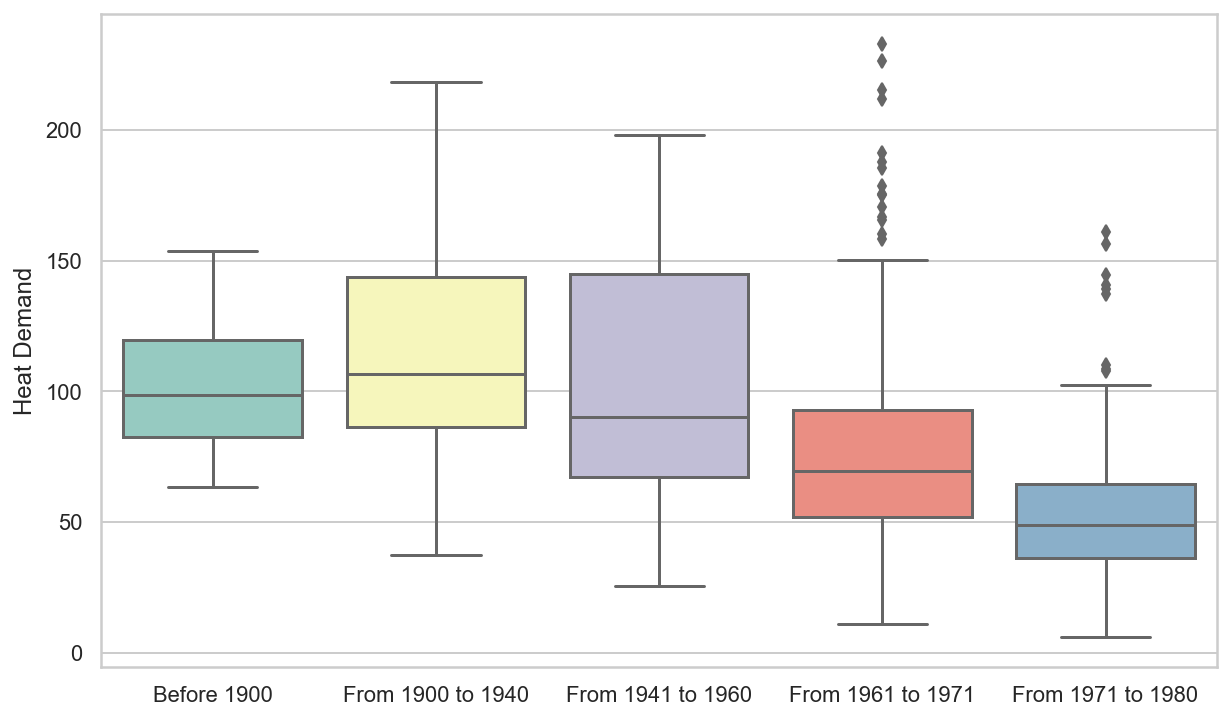

In [20]:
fig, ax = plt.subplots(1,1)
ax = sns.boxplot(x="Period", y="Heat Demand", data=buildings, palette="Set3")
ax.set_xlabel("")
plt.show()

In [21]:
buildings.groupby("Period").size()

Period
Before 1900           19
From 1900 to 1940    132
From 1941 to 1960     90
From 1961 to 1971    312
From 1971 to 1980    261
dtype: int64

In [22]:
labels = ["Detached", "From 2 to \n4 dwellings","From 5 to \n9 dwellings", 
          "From 10 to \n19 dwellings","From 20 to \n39 dwellings", "40 dwellings \nor more"]
buildings["Dwellings Cat"] = pd.cut(x=buildings["Number of Dwellings"], bins=[0,1,4,9,19,39,np.inf], labels=labels)

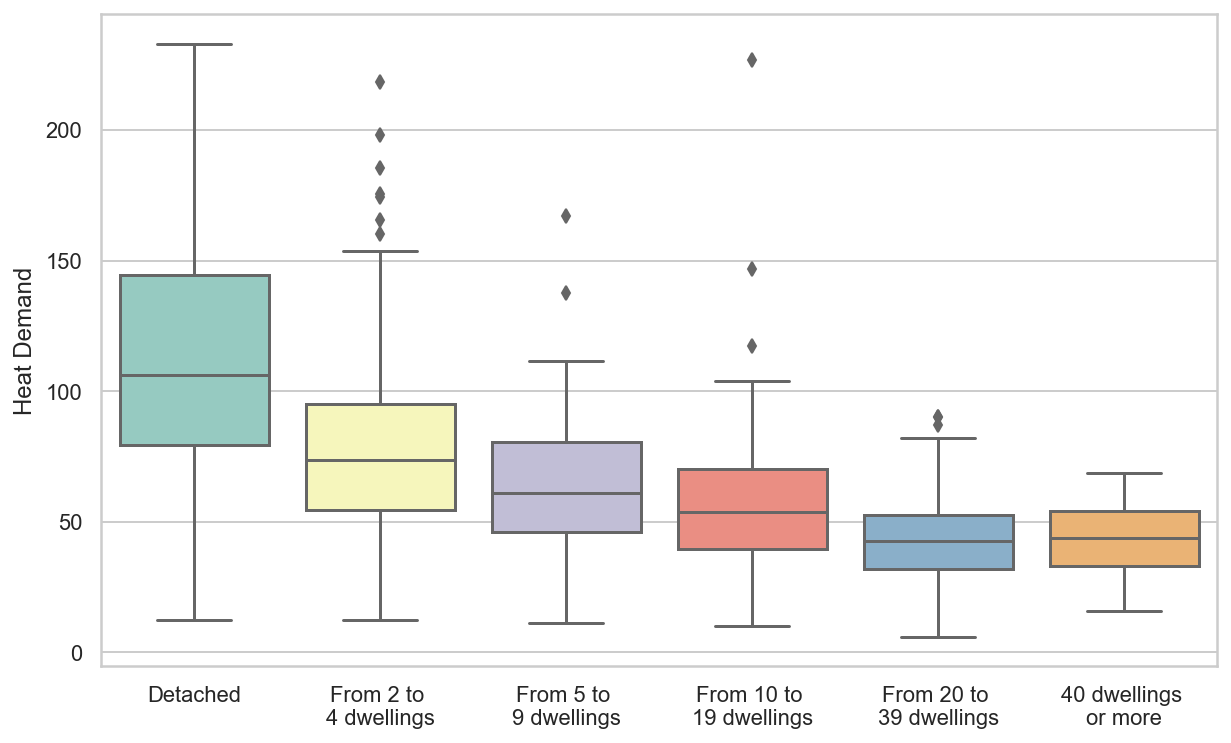

In [23]:
fig, ax = plt.subplots()
sns.boxplot(x="Dwellings Cat", y="Heat Demand", data=buildings, palette="Set3")
ax.set_xlabel("")
plt.show()

In [24]:
buildings.groupby("Dwellings Cat").size()

Dwellings Cat
Detached                     261
From 2 to \n4 dwellings      183
From 5 to \n9 dwellings      111
From 10 to \n19 dwellings    155
From 20 to \n39 dwellings     82
40 dwellings \nor more        22
dtype: int64

In [25]:
labels = ["No courtyard", "1 courtyard", "2 or more\n courtyards"]
buildings["Courtyards Cat"] = pd.cut(x=buildings["Number of Courtyards"], bins=[-np.inf, 0, 1, np.inf], labels=labels)

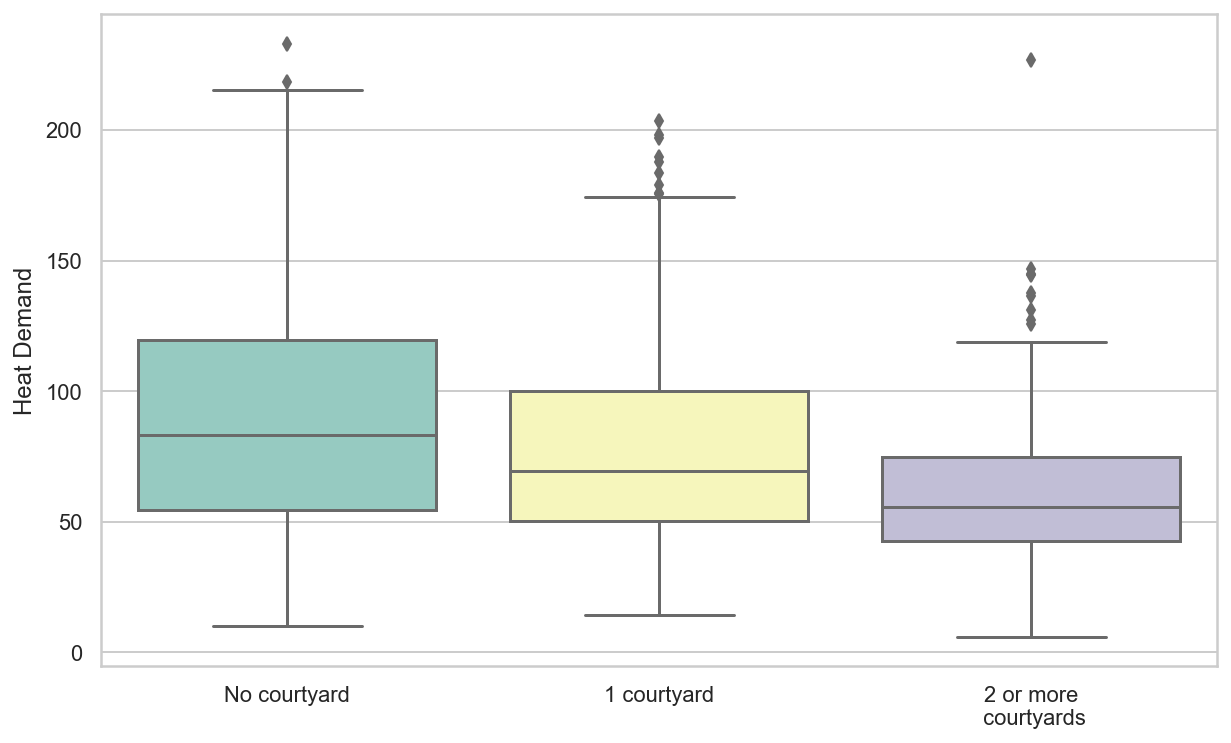

In [26]:
fig, ax = plt.subplots()
sns.boxplot(x="Courtyards Cat", y="Heat Demand", data=buildings, palette="Set3")
ax.set_xlabel("")
plt.show()

In [27]:
buildings.groupby("Courtyards Cat").size()

Courtyards Cat
No courtyard              313
1 courtyard               284
2 or more\n courtyards    217
dtype: int64

In [28]:
labels = ["No party wall", "Has party wall"]
buildings["Party Wall Cat"] = pd.cut(x=buildings["Party Wall Surface"], bins=[-np.inf,0, np.inf], labels=labels)

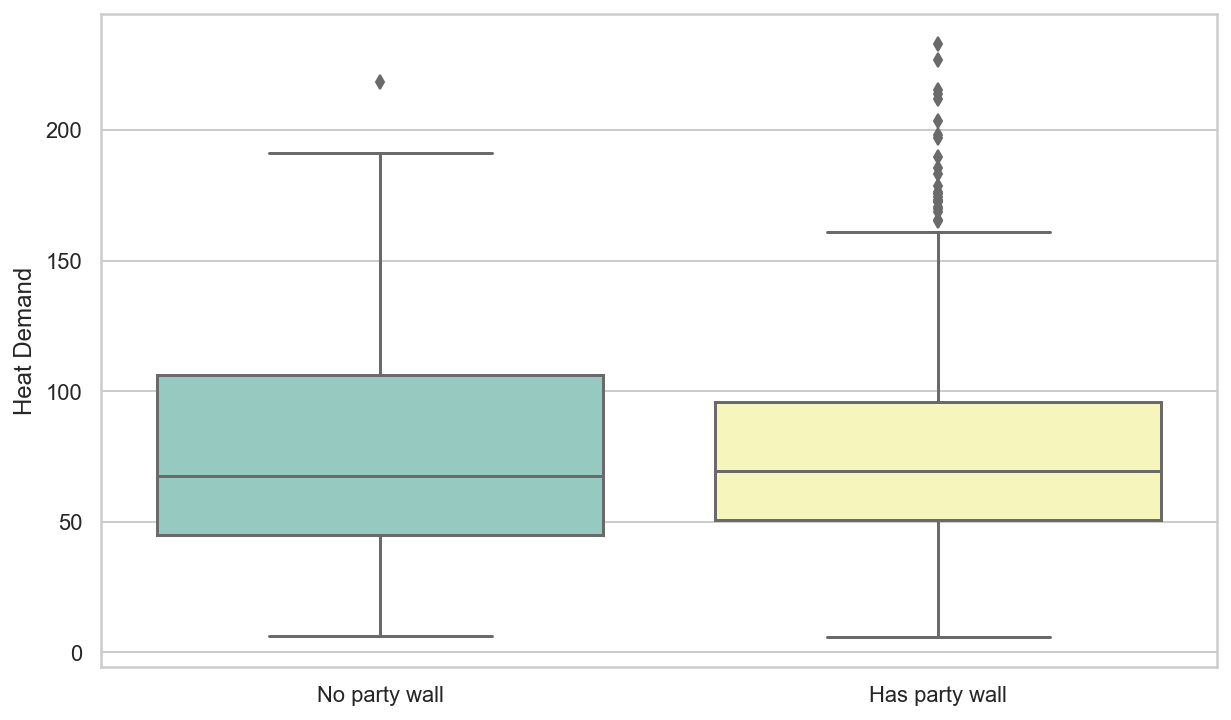

In [29]:
fig, ax = plt.subplots()
sns.boxplot(x="Party Wall Cat", y="Heat Demand", data=buildings, palette="Set3")
ax.set_xlabel("")
plt.show()

In [30]:
buildings.groupby("Party Wall Cat").size()

Party Wall Cat
No party wall     303
Has party wall    511
dtype: int64

It is very common to missinterpret results as the ones shown above. At the same time that some differences can be observed between groups (except in the case of the Party Wall category) **there is not enough statistical evidence to know whether these are systematic differences between the groups or simply random fluctuations**.

A significant difference would produce boxplots with none or practically no overlapping values between groups. I.e., wiskers in the boxplots wouldn't be overlapped.

Another useful thing to do in a Machine Learning project is combining numerical attributes. This is done trying to produce more relevant attributes to improve the model's power.

In [31]:
buildings["Wrapping Sfc. by Floor"] = buildings["Wrapping Surface"]/buildings["Number of Floors"]

In [32]:
corr_matrix = buildings.corr()
corr_matrix["Heat Demand"].sort_values(ascending=False)

Heat Demand                  1.000000
X Coord                      0.131918
Wrapping Sfc. by Floor      -0.095201
Party Wall Surface          -0.121931
Y Coord                     -0.213433
Number of Courtyards        -0.271266
Roof Surface                -0.351795
Contact w/Terrain Surface   -0.380477
Openings Surface            -0.387990
Year                        -0.413464
Facade Surface              -0.415852
Wrapping Surface            -0.464968
Number of Dwellings         -0.465891
Number of Floors            -0.627875
Name: Heat Demand, dtype: float64

# Prepare Data for ML ALgorithms

The **first thing is to revert to a clean training set and separate predictors from labels**, as we don't necessarily want to apply the same transformations to each one of them. 

We'll work with a copy of `buildings_train_set`, overwriting `buildings` as we did earlier (notice that `drop()` will create a copy of the data and it does not affect `buildings_train_set`).

In [33]:
buildings = buildings_train_set.drop("Heat Demand", axis=1)
buildings_labels = buildings_train_set["Heat Demand"].copy()

## Outliers

Data preparation must include outlier removal. Outliers, or in other words, data noise, produce less consistent models. Let's plot the distribution of the target variable to see if we can easily detect outliers.

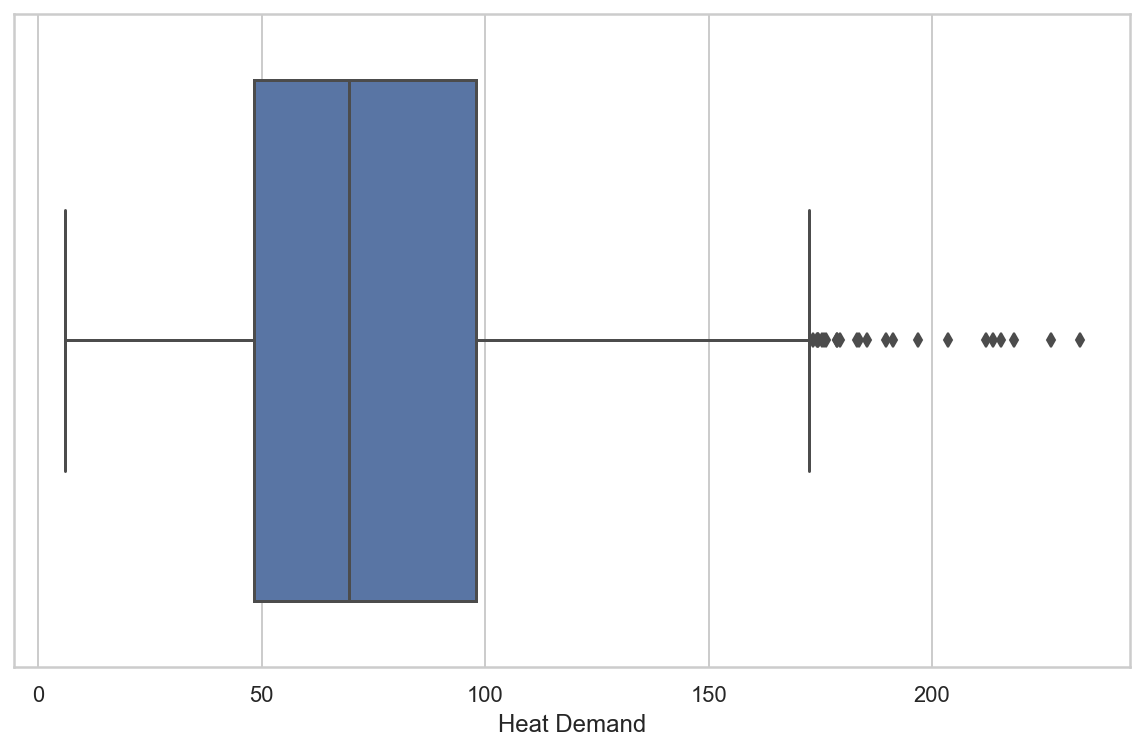

In [34]:
sns.boxplot(x=buildings_labels)
plt.show()

As we can see above, there are a few points over the 75% quantile of the distribution (to the right of the rightest wisker of the boxplot). It is hard to determine if all of them should be considered outliers.

If we use the IQR approach to delete outliers, we also have to take into account the lower part of the distribution.

In [35]:
def drop_outliers_by_iqr(s, variable_idx=0):
    IQR = s.quantile(.75) - s.quantile(.25)
    low_limit = s.quantile(.25) - 1.5*IQR
    top_limit = s.quantile(.75) + 1.5*IQR
    outlier_condition = (s > low_limit) & (s < top_limit)
    return s[outlier_condition]

In [36]:
buildings_labels_iqr = drop_outliers_by_iqr(buildings_labels, 0)
pctg = 100*(buildings_labels.shape[0] - buildings_labels_iqr.shape[0]) / (buildings_labels.shape[0])
print("We would be deleting a {:.2f}% of the total rows".format(pctg))

We would be deleting a 3.53% of the total rows


Another approach is calculating the `z-score` and setting a threshold to consider wether a point is an outiler or not. We are taking a threshold of 3 (i.e., 3 standard deviations from the mean) and the absolute `z-score` value to simplify things.

In [37]:
from scipy import stats
import numpy as np

def drop_outliers_by_zscore(s, threshold=3):  
    z_score = np.abs(stats.zscore(s))
    idx = np.where(z_score < threshold)
    return s.iloc[idx[0],]

In [38]:
buildings_labels_z = drop_outliers_by_zscore(buildings_labels, threshold=3)
sentence = "In this case, we would be deleting a "
pctg = 100*(buildings_labels.shape[0] - buildings_labels_z.shape[0]) / (buildings_labels.shape[0])
print(sentence, "{:.2f}% of the data".format(pctg))

In this case, we would be deleting a  0.92% of the data


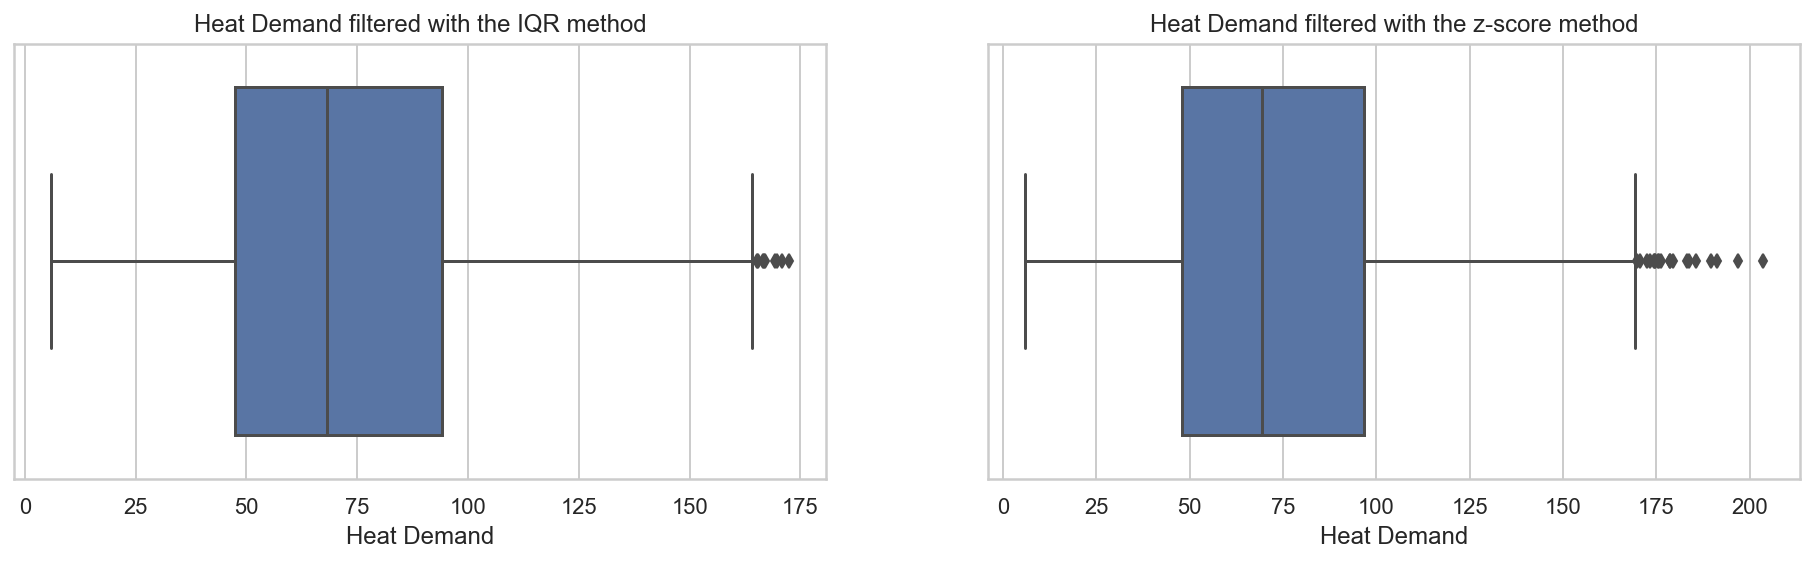

In [39]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
sns.boxplot(buildings_labels_iqr)
plt.title("Heat Demand filtered with the IQR method")
plt.subplot(122)
sns.boxplot(buildings_labels_z)
plt.title("Heat Demand filtered with the z-score method")
plt.show()

In this ocassion, we are trying the `z-score` method as it is a less restrictive one and it will keep more variablity in data.

In [40]:
buildings = buildings.loc[buildings_labels_z.index]
buildings_labels = buildings_labels.loc[buildings_labels_z.index]

## Categorical Attributes

Machine Learning Models require numerical data to be able to work. Then, categorical data must be treated before being feeded to them. There are two main ways to deal with this.

The following are the categorical attributes in the dataset.

In [41]:
buildings_cat = buildings.select_dtypes(("object", "category"))
buildings_cat_names = buildings_cat.columns.values.tolist()
buildings_cat_names

['District',
 'Main Orientation',
 'GF Usage',
 'Type of Roof',
 'Type of Opening',
 'Type of Party Wall',
 'Type of Facade']

Things we know about them are that those starting with "Type of" are variables related to the physical characteristics of the wraping surface. That is why they are also related to the surface transmitance. We can a apply an ordered transformation to those categories. 

This is related with the first method to transform categories into numbers: categories are replaced by numbers in an speciffic order, which then will be interpreted in a hierarchical way by the model.

In [42]:
buildings_cat_order = [c for c in buildings_cat_names if c.startswith("Type")]

In [43]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
buildings_cat_ordered = ordinal_encoder.fit_transform(buildings_cat[buildings_cat_order])

Each column in the array represents an attribute.

In [44]:
buildings_cat_ordered

array([[3., 3., 1., 0.],
       [2., 2., 0., 0.],
       [3., 2., 2., 2.],
       ...,
       [1., 2., 1., 2.],
       [1., 2., 0., 0.],
       [1., 2., 1., 2.]])

The categories remain in the `ordinal_encoder`'s memory to be accessed any time. This will be specially handy when interpreting the results.

In [45]:
ordinal_encoder.categories_

[array(['C1', 'C2', 'C3', 'C4'], dtype=object),
 array(['H1', 'H2', 'H3', 'H4', 'H5'], dtype=object),
 array(['0', 'M1', 'M2', 'M3'], dtype=object),
 array(['F1', 'F2', 'F3'], dtype=object)]

The other method consist in replacing the categorical variables by _dummy variables_. This is, replacing the categorical attribute by a new column for each category in it, and then, asigning a 1 for the column corresponding to the instance's category and a 0 for the rest.

In [46]:
buildings_cat_1hot = [c for c in buildings_cat_names if c not in buildings_cat_order]

In [47]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
buildings_cat_1hot = cat_encoder.fit_transform(buildings_cat[buildings_cat_1hot])

Now, each column in the array corresponds to a category in the original attribute.

In [48]:
buildings_cat_1hot.toarray()

array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [49]:
cat_encoder.categories_

[array(['Marianao', 'Vinyets'], dtype=object),
 array(['E', 'N', 'NE', 'NW', 'S', 'SE', 'SW', 'W'], dtype=object),
 array(['Commercial', 'Dwelling', 'Industrial', 'Storage'], dtype=object)]

**In this project we will opt for using the second method to perform all the transformations over the catergorical attributes. That is, with the `OneHotEncoder()` class.** Models should be able to detect differences between classes without having to establish them in an orderly manner.

## Custom Transformers

Custom Transformers will give us the option to produce more complex data preparation steps than the standard ones provided by Scikit-Learn. We need to create a custom class to do so.

Hence, let's create a custom transformer to discretize some numerical variables.

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

year_idx, partyw_idx = 2, 7
courtyards_idx, dwellings_idx = 10, 11

class DiscretizeAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_discretized_attributes=True):
        self.add_discretized_attributes = add_discretized_attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not self.add_discretized_attributes:
            return X
        else:
            X = np.array(X)
            period = np.digitize(X[:,year_idx], bins=np.array([1899, 1940, 1960, 1970, 1980]), right=True)
            party_wall_cat = np.digitize(X[:,partyw_idx], bins=np.array([0.0, np.inf]), right=True)
            courtyards_cat = np.digitize(X[:,courtyards_idx], bins=np.array([0.0, 1, np.inf]), right=True)
            dwellings_cat = np.digitize(X[:,dwellings_idx], bins=np.array([1,4,9,19,39,np.inf]), right=True)
        return np.c_[X, period, party_wall_cat, courtyards_cat, dwellings_cat]

The following are the attributes that we want to discretize.

In [51]:
buildings_num = buildings.select_dtypes(("float64", "int64"))
buildings_num.iloc[:,[year_idx, partyw_idx, courtyards_idx, dwellings_idx]]

,Year,Party Wall Surface,Number of Courtyards,Number of Dwellings
483,1965,3.129,0,1
217,1964,0.000,0,1
289,1974,180.054,1,16
18,1974,118.650,1,4
810,1967,0.000,0,2
...,...,...,...,...
371,1978,311.670,1,15
795,1942,87.930,0,2
455,1972,40.800,1,3
361,1966,0.000,1,4


Now we can use our custom class to discretize them.

In [52]:
def create_discretized_attrs(df):
    discretizer = DiscretizeAttributes()
    discrete_attrs = discretizer.transform(df)
    return pd.DataFrame(discrete_attrs[:,12:],
                        columns = ["Period", "Party Wall Cat", "Courtyards Cat", "Dwellings Cat"],
                        index = df.index)

buildings_extra_attrs = create_discretized_attrs(buildings_num)

Better if we check that all transformations were made correctly! It can be done visually with `Party Wall Cat` and `Courtyards Cat` which have fewer categories (have party wall = 1, it has not = 0; and has 0, 1 or 2 or more courtyards). 

See in the DataFrames above how the numbers in `extra_attrs` correspond with the ones of `buildings_num`. 

For the year and number of dwellings is slightly harder as there are a higher number of categories. Let's do it programatically.

In [53]:
bins=np.array([1899, 1940, 1960, 1970, 1980])
x = np.array(buildings_num.iloc[:5,year_idx])
inds = np.digitize(x, bins)

for n in range(x.size):
    print(bins[inds[n]-1], "<=", x[n], "<", bins[inds[n]])

1960 <= 1965 < 1970
1960 <= 1964 < 1970
1970 <= 1974 < 1980
1970 <= 1974 < 1980
1960 <= 1967 < 1970


In [54]:
bins=np.array([1,4,9,19,39,np.inf])
x = np.array(buildings_num.iloc[:5,dwellings_idx])
inds = np.digitize(x, bins)

for n in range(x.size):
    print(bins[inds[n]-1], "<=", x[n], "<", bins[inds[n]])

1.0 <= 1 < 4.0
1.0 <= 1 < 4.0
9.0 <= 16 < 19.0
4.0 <= 4 < 9.0
1.0 <= 2 < 4.0


That's it! Bins have been set correctly. So, now we append the extra columns to the whole dataset. `pandas.concat()` performs this joining the two DataFrames by row index.

In [55]:
buildings = pd.concat([buildings, buildings_extra_attrs.astype("category")], axis=1)

Thus, we have appended our new attributes to our training set, setting the extra attributes as categorical.

In [56]:
list(zip(range(len(buildings)), buildings.columns.values))

[(0, 'X Coord'),
 (1, 'Y Coord'),
 (2, 'District'),
 (3, 'Year'),
 (4, 'Main Orientation'),
 (5, 'GF Usage'),
 (6, 'Roof Surface'),
 (7, 'Facade Surface'),
 (8, 'Openings Surface'),
 (9, 'Wrapping Surface'),
 (10, 'Party Wall Surface'),
 (11, 'Contact w/Terrain Surface'),
 (12, 'Type of Roof'),
 (13, 'Type of Opening'),
 (14, 'Type of Party Wall'),
 (15, 'Type of Facade'),
 (16, 'Number of Floors'),
 (17, 'Number of Courtyards'),
 (18, 'Number of Dwellings'),
 (19, 'Period'),
 (20, 'Party Wall Cat'),
 (21, 'Courtyards Cat'),
 (22, 'Dwellings Cat')]

To completely implement the transformations that were expolred early, we need to add a transformer class to compute the `Wrapping Sfc. by Floor` attribute. This class will be implemented over the list of numerical attributes separatedly as we will see in the next section.

In [57]:
buildings_num = buildings.select_dtypes(("float64", "int64"))
list(zip(range(len(buildings_num)), buildings_num.columns))

[(0, 'X Coord'),
 (1, 'Y Coord'),
 (2, 'Year'),
 (3, 'Roof Surface'),
 (4, 'Facade Surface'),
 (5, 'Openings Surface'),
 (6, 'Wrapping Surface'),
 (7, 'Party Wall Surface'),
 (8, 'Contact w/Terrain Surface'),
 (9, 'Number of Floors'),
 (10, 'Number of Courtyards'),
 (11, 'Number of Dwellings')]

In [58]:
wrapping_sf_ix, floors_ix = 6, 9

class CombineAttrs(BaseEstimator, TransformerMixin):
    def __init__(self, combine_attrs=True):
        self.combine_attrs = combine_attrs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        wrapping_sf_floor = X[:, wrapping_sf_ix] / X[:, floors_ix]
        if self.combine_attrs:
            return np.c_[X, wrapping_sf_floor]
        else:
            return np.array(X)

We will use this in the transformation pipelines.

## Feature Scaling

The year a building was built has a very different scale than the number of floors it can have. This can degrade the predictive performance of many machine learning algorithms.

To tackle this, we can use scaling techniques. In this project we will try several methods, to go beyond the default class used in many Machine Learning Projects `StandardScaler()`. Scikit-Learn provides several classes (not all are included here) to do so.

No scaling will be tested too.

In [59]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

class CustomScaler(BaseEstimator, TransformerMixin):
    """
    Choose one of the following values for the scaler parameter:
    -  None: Data wont be scaled
    - 'standard': StandardScaler()
    - 'minmax': MinMaxScaler()
    - 'maxabs': MaxAbsScaler()
    - 'robust': RobustScaler()
    """
    def __init__(self, scaler='standard'):
        valid_scalers = [None, 'standard', 'minmax', 'maxabs', 'robust']
        self.scaler = scaler
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.scaler is None:
            return np.array(X)
        elif self.scaler == 'standard':
            return StandardScaler().fit_transform(X)
        elif self.scaler == 'minmax':
            return MinMaxScaler().fit_transform(X)
        elif self.scaler == 'maxabs':
            return MaxAbsScaler().fit_transform(X)
        elif self.scaler == 'robust':
            return RobustScaler().fit_transform(X)
        else:
            raise ValueError("Invalid Scaler: '{}'; choose one of:\n {}".format(self.scaler, valid_scalers))

For more information on how these classes work, [visit this page](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

## Transformation Pipelines

To have a better control over the transformation process, we can implement Pipelines. This will help us avoing to do each step manually. With pipelines, every stage of the transformation process is produced automatically in the estipulated orther. The ouput of the preceding stage will be the input of the following one.

This, together with the custom transformers will make these transformations optional and combinable, in an automated maner. Thus we can test which mix of hyperparameters give us the best model performance.

There are some missing values in the coordinates as result of poorly gathered data. Most algorithms are not able to deal with missing values. The options are:

* Get rid of the corresponding buildings
* Get rid of the hole attribute
* Set the values to some value (zero, the mean, the median, etc.)

Here, we will try the Scikit-Learn's `KNNImputer`. This imputer will take the mean of its `k` nearest neighbours. The nearest neighbours are selected through the euclidean distance between individuals, taking into account all attributes. This will tend to emulate the geographical distribution of buildings that have similar characteristics to those whose coordinates are missing.

We will include all these transformations in a pipeline to deal with the numerical attributes.

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=3, weights="uniform")),
    ('combine_attrs', CombineAttrs(combine_attrs=True)),
    ('custom_scaler', CustomScaler(scaler='standard'))
])

Next, we should include a pipeline to transform categorical attributes.

Previously, we added some extra attributes by discretizing some numerical features and by attaching them to the original dataset. This step was not included in the numerical pipeline but performed separatedly. There will be, however, a step in the categorical pipeline to make the decision of adding them optional.

The final step in the categorical pipeline will be to impute _one-hot encoding_ over all the categorical variables.

In [61]:
buildings_cat = buildings.select_dtypes(("category", "object"))
list(zip(range(len(buildings_cat)), buildings_cat.columns))

[(0, 'District'),
 (1, 'Main Orientation'),
 (2, 'GF Usage'),
 (3, 'Type of Roof'),
 (4, 'Type of Opening'),
 (5, 'Type of Party Wall'),
 (6, 'Type of Facade'),
 (7, 'Period'),
 (8, 'Party Wall Cat'),
 (9, 'Courtyards Cat'),
 (10, 'Dwellings Cat')]

In [64]:
cat_extra_attrs_idx = list(range(7,11))

class CatExtraAttrs(BaseEstimator, TransformerMixin):
    def __init__(self, add_cat_extra_attribs=True):
        self.add_cat_extra_attribs = add_cat_extra_attribs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.add_cat_extra_attribs:
            return X
        else:
            X = np.array(X)
            return np.delete(X, cat_extra_attrs_idx, axis=1)

In [65]:
cat_pipeline = Pipeline([
    ('add_cat_extra_attrs', CatExtraAttrs(add_cat_extra_attribs=True)),
    ('one_hot_encoder', OneHotEncoder())
])

Finally, we use the `ColumnTransformer()` class to implement all transformations (over numerical and categoriacal data) in the same pipleine.

In [66]:
from sklearn.compose import ColumnTransformer

num_attribs = list(buildings_num.columns.values)
cat_attribs = list(buildings_cat.columns.values)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

buildings_prepared = full_pipeline.fit_transform(buildings)

# Model Selection and Training

All the hardest work is already done. We have gone through data exploration, the visual analysis, and the data preparation steps. Those usually are the most time consuming ones. The following steps are where the fun part is. Let's dive in the Machine Learning Models!

This step consists in trying out several models (for a regression task, in this case) to see which performs best. Let’s start simple by training a Linear Regression Model first.

In [67]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(buildings_prepared, buildings_labels)

LinearRegression()

Let's print some target values and some predictions to see how it is working.

In [68]:
some_data = buildings.iloc[:5]
some_labels = buildings_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [117.8515625  118.4296875   59.8125      69.58203125  24.5234375 ]


In [69]:
print("Labels:", list(some_labels))

Labels: [83.80830072, 88.95706649, 53.80141858, 88.2675733, 12.44289642]


It works, although the predictions are not exactly accurate. Let's measure this Regression Model's RMSE on the whole training set. We are using Scikit-Learn's `mean_squared_error()` function to do this.

In [70]:
from sklearn.metrics import mean_squared_error

buildings_predictions = lin_reg.predict(buildings_prepared)
lin_mse = mean_squared_error(buildings_labels, buildings_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

23.594860561596818

This is not a bad score at all. Heat Demand median values are between X and Y kWh, so a typical prediction error of 23.6 kWh is not a big deal.

Let's try other models anyway. We can experiment now with a Decision Tree.

In [71]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(buildings_prepared, buildings_labels)

DecisionTreeRegressor()

In [72]:
buildings_predictions = tree_reg.predict(buildings_prepared)
tree_mse = mean_squared_error(buildings_labels, buildings_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It could seems like we have found the perfect model, but slow down! It is more likely that the model is overfitting than it is perfect. 

At this point, it is important to **remember that we don't want to touch the test set until we are ready to launch a model that we are confident about**, so before doing this, we will use a part of the training set and part of it for validation in the operation known as _cross-validation_.

## Better Evaluation Using Cross-Validation

To put it in other words, _cross-validation_ is an iterative process which consists in training the model in different subsets of the (training) data, to then get the final predictions by averaging the results of each step in the iteration. It is used to ensure that the results are independent of the partition of the data.

The fastest way to implement cross-evaluation is using the Scikit-Learn's _K-fold cross validation_ feature. The following code randomly splits the training set into 10 distinct subsets called _folds,_ then trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [73]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, buildings_prepared, buildings_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

This process will output a series of 10 scores, one for each cross validation set. To get the overall error, we can average them.

In [74]:
def display_result(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std Deviation: ", scores.std())
    
display_result(tree_rmse_scores)

Scores:  [32.57217904 28.83861652 32.4643665  37.83727764 34.50944737 31.29889301
 33.25633962 31.72899783 32.72794514 33.6708815 ]
Mean:  32.89049441651071
Std Deviation:  2.2009960352205753


A `RandomForestRegressor`, is an esamble method. It takes several trees and averages the results of their predictions.

In [75]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(buildings_prepared, buildings_labels)

RandomForestRegressor(random_state=42)

In [76]:
%%time
scores = cross_val_score(forest_reg, buildings_prepared, buildings_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

CPU times: user 6.6 s, sys: 92.8 ms, total: 6.69 s
Wall time: 7.02 s


Notice that we used the `neg_mean_squared_error_` scoring. It is because the Scikit-Learn's cross-validation feature expects a utility function (greater is better) rather than a cost function (lower is better), so the scoring is actually the opposite of the MSE (conceptually, a negative value), which is why we computed the `-scores` before calculating the root.

In [77]:
buildings_predictions = forest_reg.predict(buildings_prepared)
forest_mse = mean_squared_error(buildings_labels, buildings_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

8.502109298321999

In [78]:
display_result(forest_rmse_scores)

Scores:  [19.42490752 23.30564122 23.72901783 22.99381122 26.0073711  22.06358871
 23.84696743 21.33527826 24.40731054 25.50616146]
Mean:  23.262005529937706
Std Deviation:  1.8544785429347912


Random Forests seems to work better than Linear Regression! However, notice that **the score on the train set is quite lower than in the validation sets**. This is due to **overfitting** in the training set. The possible solutions to this common Machine Learning problem are:

* Geting more data
* Feeding the model with new and more significat attributes
* Regularizing the model, i.e., use hyperparameters to apply constrains over it.

**We have to try several other models before we dive deeper into Random Forest and fine-tuning**. E.g., we should try out Support Vector Machines with different kernels, and possibly a neural network, without spending too much time tweaking the hyperparameters. **The goal is to shortlist a few (two to five) promising models**.

Let's, then, try the Scikit-Learn's Super Vector Machine Regressor (`SVR`).

In [79]:
from sklearn.svm import SVR

svm_reg_linear = SVR(kernel='linear')
svm_reg_linear.fit(buildings_prepared, buildings_labels)
svm_linear_scores = cross_val_score(svm_reg_linear, buildings_prepared, buildings_labels,
                             scoring="neg_mean_squared_error", cv=10)
svm_linear_rmse_scores = np.sqrt(-scores)

In [80]:
svm_linear_rmse_scores.mean()

23.262005529937706

In [81]:
buildings_predictions = svm_reg_linear.predict(buildings_prepared)
svm_linear_mse = mean_squared_error(buildings_labels, buildings_predictions)
svm_linear_rmse = np.sqrt(svm_linear_mse)
svm_linear_rmse

24.886167512882977

And now with a `rbf` kernel.

In [82]:
svm_reg_rbf = SVR(kernel='rbf')
svm_reg_rbf.fit(buildings_prepared, buildings_labels)
svm_rbf_scores = cross_val_score(svm_reg_rbf, buildings_prepared, buildings_labels,
                             scoring="neg_mean_squared_error", cv=10)
svm_rbf_rmse_scores = np.sqrt(-scores)

In [83]:
svm_rbf_rmse_scores.mean()

23.262005529937706

In [84]:
buildings_predictions = svm_reg_rbf.predict(buildings_prepared)
svm_rbf_mse = mean_squared_error(buildings_labels, buildings_predictions)
svm_rbf_rmse = np.sqrt(svm_rbf_mse)
svm_rbf_rmse

31.859868410545108

As we can see, the `SVR`'s RMSE is a little bit worse than the `RandomForestRegressor`'s one.

Since there is not much difference in the point estimates of the generalization error between the models we tried out, we may not be sure to decide for one of them.

To have an idea of how precise our models are, we can set a 95% _confidence interval_ for the generalization error using `scipy.stats.t.interval()`. 

This statistical technique also fits like a glove in the scenario where you are trying a model different from the current production one and you don't know if such a point estimate of the generalization error after testing &mdash;in the test set&mdash; your new model is quite enough to convince you to launch it.

In [85]:
predictions = {
    "lin_reg": lin_reg.predict(buildings_prepared),
    "forest_reg": forest_reg.predict(buildings_prepared),
    "svm_linear": svm_reg_linear.predict(buildings_prepared),
    "svm_rbf": svm_reg_rbf.predict(buildings_prepared)
}

In [86]:
from scipy import stats

confidence = .95

for key in predictions.keys():
    print(key)
    squared_errors = []
    for i in range(len(buildings_labels)):
        squared_errors.append((predictions[key][i] - buildings_labels.iloc[i]) ** 2)
    if key == "forest_reg": 
        intervals = [forest_rmse_scores.mean()-forest_rmse_scores.std(), forest_rmse_scores.mean()+forest_rmse_scores.std()]
    else:
        squared_errors = np.array(squared_errors)
        intervals = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, # minus one degree of freedom
                                                loc=np.mean(squared_errors),
                                                scale=stats.sem(squared_errors)))
    print(intervals)

lin_reg
[21.90195276 25.17418032]
forest_reg
[21.407526987002914, 25.1164840728725]
svm_linear
[22.87844038 26.7435905 ]
svm_rbf
[29.58345287 33.98413963]


At this point we could choose almost any model that we have tried, as the obtained scores are not really that different. In this type of scenario we should opt for explainability (it's better to know what models are doing!). 

From the models tried, Linear Regression and Random Forest are the most explainable ones. It is not important here to know why, but to get the concept.

Based on this premise and the fact that **Random Forest** obtained a slightly better score than Linear Regression, we will choose the first one as the definitive model for our data.

## Fine-Tunning

Now that we know that we have selected our model, it is time to try out several parameters to make the best of it. One of the main approaches to do that is using Scikit-Learn's `GridSearch()`. We provide a series of parameters and the algorithm will try all the possible combinations to search for the one which leads to the best result.

In [87]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[30, 100, 130, 200, 230], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [30, 230, 530, 1030, 1530], 'max_features':[4, 6, 8, 12]}
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                              scoring='neg_mean_squared_error',
                              return_train_score=True)

In [88]:
%%time
grid_search.fit(buildings_prepared, buildings_labels)

CPU times: user 3min 3s, sys: 3.57 s, total: 3min 6s
Wall time: 3min 8s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [30, 100, 130, 200, 230]},
                         {'bootstrap': [False], 'max_features': [4, 6, 8, 12],
                          'n_estimators': [30, 230, 530, 1030, 1530]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [89]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 12, 'n_estimators': 1530}

In [90]:
curves = grid_search.cv_results_
for mean_score, params in zip(curves["mean_test_score"], curves["params"]):
    print(np.sqrt(-mean_score), params)

26.81654774212237 {'max_features': 2, 'n_estimators': 30}
26.340281868939826 {'max_features': 2, 'n_estimators': 100}
26.38369965916975 {'max_features': 2, 'n_estimators': 130}
26.195586082994076 {'max_features': 2, 'n_estimators': 200}
26.249070358824355 {'max_features': 2, 'n_estimators': 230}
25.743666240027604 {'max_features': 4, 'n_estimators': 30}
25.539074583134248 {'max_features': 4, 'n_estimators': 100}
25.371393824322944 {'max_features': 4, 'n_estimators': 130}
25.240900655612215 {'max_features': 4, 'n_estimators': 200}
25.30900463200094 {'max_features': 4, 'n_estimators': 230}
25.370885305287064 {'max_features': 6, 'n_estimators': 30}
25.008851909774265 {'max_features': 6, 'n_estimators': 100}
24.998313389390265 {'max_features': 6, 'n_estimators': 130}
24.6927114493651 {'max_features': 6, 'n_estimators': 200}
24.67715900914879 {'max_features': 6, 'n_estimators': 230}
25.543212770915975 {'max_features': 8, 'n_estimators': 30}
24.709279232453436 {'max_features': 8, 'n_estimato

The main problem with this approach is that we generally do not know which ranges of parameters are the optimal. The best value for the `n_estimators` parameter was the highest value of the ones passed. That might indicate that the best value for this parameter is actually above the one we provide, and that we should expand the range we gave in the `GridSearchCV` distribution and try again.

So, instead of doing this, we can prove another approach to look for the best parameters for a model, which is the Scikit-Learn's `RandomizedSearchCV()` class. The latter usually means achieving better results in the same amount of time.

In this case, we can stipulate any random distribution to search for each parameter. As our parameters are integers, we will use the `scipy.stats.randint()` function, that generates a discrete uniform distribution in which any value in the range provided is equally likely to happen. 

In [91]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distrib = {
    'bootstrap': [True, False],
    'n_estimators':randint(1,1000),
    'max_features': randint(4,45)
}

forest_reg = RandomForestRegressor()
random_search = RandomizedSearchCV(forest_reg, param_distrib, n_iter=50, 
                                   cv=5, n_jobs=2, random_state=42,
                                   scoring='neg_mean_squared_error')
random_search.fit(buildings_prepared, buildings_labels)

CPU times: user 1.91 s, sys: 150 ms, total: 2.06 s
Wall time: 3min 40s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1230088e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1234a4f70>},
                   random_state=42, scoring='neg_mean_squared_error')

In [92]:
negative_mse = random_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

23.56815211873379

And indeed the `RandomizedSearchCV()` improved by 0.5 points of error estimate expending the same amount of time than `GridSearchCV()`! The best parameters for the model were the following.

In [93]:
random_search.best_params_

{'bootstrap': True, 'max_features': 26, 'n_estimators': 331}

Now it is time to implement a single pipeline with preparation and prediction. 

In [94]:
from sklearn.model_selection import RandomizedSearchCV

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('forest_prediction', RandomForestRegressor(**random_search.best_params_))
])

prepare_select_and_predict_pipeline.fit(buildings, buildings_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('combine_attrs',
                                                                   CombineAttrs()),
                                                                  ('custom_scaler',
                                                                   CustomScaler())]),
                                                  ['X Coord', 'Y Coord', 'Year',
                                                   'Roof Surface',
                                                   'Facade Surface',
                                                   'Openings Surface',
                                                   'Wrapping Surface',
                                     

Let's see how does the predictions look like!

In [95]:
some_data = buildings[:4]
some_labels = buildings_labels[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [122.31370258 102.47481625  47.82353461  78.31273223]
Labels:		 [83.80830072, 88.95706649, 53.80141858, 88.2675733]


Now we can try out several hyperparameters that have not been explored yet, that is, those related to the preparation process.

In [96]:
# uncomment to see pipeline avilable parameters
# prepare_select_and_predict_pipeline.get_params().keys()

In [97]:
param_grid = [{
    'preparation__num__knn_imputer__n_neighbors': range(1,5),
    'preparation__num__combine_attrs__combine_attrs':[True,False],
    'preparation__num__custom_scaler__scaler': [None, 'standard', 'minmax', 'maxabs', 'robust'],
    'preparation__cat__add_cat_extra_attrs__add_cat_extra_attribs': [True, False]
}]

In [98]:
grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid=param_grid, 
                                cv=5, scoring='neg_mean_squared_error')

grid_search_prep.fit(buildings, buildings_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('knn_imputer',
                                                                                          KNNImputer(n_neighbors=3)),
                                                                                         ('combine_attrs',
                                                                                          CombineAttrs()),
                                                                                         ('custom_scaler',
                                                                                          CustomScaler())]),
                                                                         ['X '
                                                                          'Coord',
                               

### Saving models

Training a model or fine-tuning it could be a very time consuming process. Instead of doing it over and over, we can save our results with the `joblib` library.

In [99]:
import joblib

joblib.dump(grid_search_prep, "models/grid_search_prep.pkl")

['models/grid_search_prep.pkl']

And then, we can load it again with the following code:

In [100]:
grid_search_prep = joblib.load("models/grid_search_prep.pkl")

In [101]:
grid_search_prep.best_params_

{'preparation__cat__add_cat_extra_attrs__add_cat_extra_attribs': False,
 'preparation__num__combine_attrs__combine_attrs': False,
 'preparation__num__custom_scaler__scaler': None,
 'preparation__num__knn_imputer__n_neighbors': 3}

Now we know that we need neither to combine attributes nor discretizing any of them. 

Though it might seem otherwise, it is not so surprising that not scaling the data is the best option to get the best of our model. The physical model used to obtain the estimate energy consumption of buildings used the attributes as they are. This behavior is not usual with models built with the right data.

## Analyzing Errors

A good way to gain insight of what is happening is by inspecting the best models. To do that, we can start by looking at the relative importances of each feature in the Random Forest model.

In [102]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([2.98724419e-02, 4.06413575e-02, 4.60536168e-02, 3.04391222e-02,
       6.00797408e-02, 8.57215729e-02, 4.81975501e-02, 2.82400420e-02,
       4.11361393e-02, 1.16741842e-01, 8.43945575e-03, 7.05947149e-02,
       3.63948083e-02, 3.46620547e-03, 3.52081403e-03, 2.39738553e-03,
       2.63566073e-03, 1.86607127e-03, 1.18020174e-02, 3.42765013e-03,
       2.10588791e-03, 1.77383399e-03, 2.53850023e-03, 4.99552050e-03,
       7.11985374e-03, 3.16527850e-03, 9.91707779e-04, 5.16334691e-03,
       1.46194641e-01, 7.63135411e-03, 3.03124268e-03, 7.89378876e-04,
       1.71745757e-03, 5.24243878e-03, 4.49698103e-03, 9.74669027e-04,
       3.82736422e-03, 3.59629807e-03, 2.61507674e-03, 8.42037636e-04,
       6.11219654e-03, 3.11983645e-03, 1.18904035e-02, 6.98420527e-04,
       5.90234035e-03, 2.53925709e-03, 3.60347641e-03, 1.20851140e-02,
       4.48186974e-03, 4.37763286e-03, 4.82116759e-03, 3.96696638e-03,
       2.99574195e-03, 4.58575416e-02, 3.16297979e-03, 1.52045321e-03,
      

To get a better understanding, let's plot the feature importances along with its corresponding attribute.

In [103]:
extra_attribs = ["wrp_sfc_per_floor"]
cat_encoder = full_pipeline.named_transformers_["cat"]["one_hot_encoder"]
cat_one_hot_attribs = cat_encoder.get_feature_names(cat_attribs)
attributes = num_attribs + list(cat_one_hot_attribs) + extra_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.146194641218212, 'Type of Roof_C3'),
 (0.1167418419986273, 'Number of Floors'),
 (0.0857215729112518, 'Openings Surface'),
 (0.07059471485690744, 'Number of Dwellings'),
 (0.06007974078447032, 'Facade Surface'),
 (0.04819755012844844, 'Wrapping Surface'),
 (0.046053616793424804, 'Year'),
 (0.04585754155035078, 'Dwellings Cat_1.0'),
 (0.0411361392507979, 'Contact w/Terrain Surface'),
 (0.040641357536662405, 'Y Coord'),
 (0.03639480833185556, 'District_Marianao'),
 (0.030439122189225305, 'Roof Surface'),
 (0.029872441933168226, 'X Coord'),
 (0.028240041981861527, 'Party Wall Surface'),
 (0.012085114014505294, 'Party Wall Cat_0.0'),
 (0.011890403520552501, 'Period_0.0'),
 (0.011802017421436965, 'Main Orientation_S'),
 (0.00843945575319424, 'Number of Courtyards'),
 (0.007631354107691159, 'Type of Roof_C4'),
 (0.007119853743805581, 'GF Usage_Industrial'),
 (0.006112196541213402, 'Type of Facade_F2'),
 (0.0059023403458396155, 'Period_2.0'),
 (0.005242438783904124, 'Type of Opening_H4'),

With this information, the next step would be proceeding to clean up our data and model. 

For example, we see how some of the extra attributes added in the data transformation process have a relatively high importance value. However, from the grid search we know that it will work better without them. Then, we could drop them.

Yet, we'll continue with the overall workflow of the Machine Learning Project and go directly to the Model Testing  step.

## Model Testing

Before testing our model, we must add the extra attributes to the Test Set to make the pipeline work.

In [104]:
X_test = buildings_test_set.drop("Heat Demand", axis=1)
y_test = buildings_test_set["Heat Demand"].copy()
X_test_num = X_test.select_dtypes(("float64", "int64"))

X_test_extra_attrs = create_discretized_attrs(X_test_num)

Then, combine all together.

In [105]:
X_test = pd.concat([X_test, X_test_extra_attrs], axis=1)

And finally make the predictions and getting the error!

In [106]:
final_model = grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

20.945903715715055

Error is similar in the training and test set and it is even lower in the latter. That means that our model is generalizing well what it is learning.

# Take aways

The main ideas to take away from this study are the following:
* In this project some of the most common problems of Machine Learning were faced:
    * Insufficient quantity of data: to design a solid building renovation strategy it would be appropriate to have more instances or cases and more information about each of them (social and demographic variables, others related to climate, etc.).
    * Poor-quality data. Validated and consolidated data are essential to build powerful models.
* In the present context, this should be tackled through making energy cosumption data accesible. This would favour governance and sustainablity.
* Machine Learning has a high potential when it comes to spending energy more wisely. **However, it is essential to accompany the increase in efficiency in a conscious reduction of consumption, especially in those that have greater availability due to their economic situation**.

While doing this excercise other ideas for Machine Learning applications regariding building stock and energy cosumption arose:

* A model to classify buildings regarding their potential to be susceptible of an renovation. This would have to be done taking into account all kind of variables to avoid producing models which impair some individuals in favour of others.
* A model to detect errors in building data collection. This way the procedure of data collection for institutions like the Cadastre could become less resource intensive.

![](img/know.jpeg)

<a id='references'></a>
# References

\[1\] [^](#top) AAVV, Master en Intervención Sostenible en el Medio Construído (2018). "Repensar lo edificado. Propuesta de Intervención Sostenible para los barrios de Marianao y Vinyets, Sant Boi de Llobregat". https://issuu.com/sergioleonardopinzon/docs/dossier_re-pensar_lo_edificado_mism.

\[2\] [^](#context) Quick, Kimberly (2015)."The Unfair Effects of IMPACT on Teachers with the Toughest Jobs". The Century Foundation. Accesed June 2020 from: https://tcf.org/content/commentary/the-unfair-effects-of-impact-on-teachers-with-the-toughest-jobs/?agreed=1

\[3\] [^](#jeavons) Bauer, Diana; Papp, Kathryn (2009). "Book Review Perspectives: The Jevons Paradox and the Myth of Resource Efficiency Improvements". Sustainability: Science, Practice, & Policy. 5 (1). doi:10.1080/15487733.2009.11908028.

\[4\] [^](#measure) Géron, Aurélien (2019). "Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow". O'Reilly. pg. 39.

\[5\] [^](#fengineering) Kuhn, M and Johnson, Kjell. 2019. “Feature Engineering and Selection: A Practical Approach for Predictive Models”. http://www.feat.engineering/numeric-one-to-many.html#binning